# DQN with two improvements

In [1]:
# From Computer vision lab 6, keeps reloading the code for the objects so that you can work on them without needing to reload the kernal
%load_ext autoreload
%autoreload 2

In [61]:
# imports
from helpers.get_available_actions import get_available_actions, adv_action_from_index
import numpy as np
from helpers.advanced_map import AdvancedMap
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch
import math
import pickle
from collections import namedtuple, deque

# determine if we are using cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Build the Deep Q Network
class DQN(torch.nn.Module):
    """Deep Q Network, sizes based upon the grid search in RLLib"""

    def __init__(self):
        """Create an instance of the network"""
        # Call the base objects init method
        super().__init__()

        # our advanced network will be sending in a 53 column list of numbers
        self.dense1 = torch.nn.Linear(53, 256)
        # normalise the data in the network
        self.norm1 = torch.nn.BatchNorm1d(256)

        self.dense2 = torch.nn.Linear(256, 256)
        self.norm2 = torch.nn.BatchNorm1d(256)

        self.dense3 = torch.nn.Linear(256, 256)
        self.norm3 = torch.nn.BatchNorm1d(256)

        # 5 potential actions
        self.dense4 = torch.nn.Linear(256, 5)

    def forward(self, x):
        """Pass the data through the network"""
        # convert the input data to a float, run it through the first dense layer, then through the first batch norm layer and then apply the relu function
        output = torch.functional.F.relu(self.norm1(self.dense1(x.float())))
        # repeat for 
        output = torch.functional.F.relu(self.norm2(self.dense2(output)))

        output = torch.functional.F.relu(self.norm3(self.dense3(output)))
        # reshape the tensor and pass it through the last stage
        return self.dense4(output.view(output.size(0), -1))

DQN()

DQN(
  (dense1): Linear(in_features=53, out_features=256, bias=True)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=256, out_features=256, bias=True)
  (norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=256, out_features=5, bias=True)
)

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) # from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

class ReplayMemory(object):
    """from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    def __init__(self, capacity):
        # uses a deque structure so that as new items are added to the end of the 'list' items at the front are pushed off of it
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Return a random sample from the memory"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def reset(self):
        # reset the memory
        self.memory = deque([], maxlen=self.memory.maxlen)

In [5]:
# Test that it works
# Get an instance of the map
amap = AdvancedMap()
# Get the normalised observations
obs, r, done = amap.convert_observations(amap.reset())
# get an instance of the model
mdl = DQN()
# put it in evaluation mode
mdl.eval()
# convert the observations to a torch tensor and reshape the array to what the model expects
out = mdl(torch.from_numpy(obs).unsqueeze(0))
# use argmax to get the index of the action to take and then use item to get it as a python number type
torch.argmax(out).item()

1

In [49]:
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

# setup the optimiser
optim = torch.optim.SGD(Q_net.parameters(), lr=0.01)

# setup the memory
memory = ReplayMemory(10000)

# setup hyper-parameters
GAMMA = 0.9 # from RLLib grid search

# from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

# from lab 6
BATCH_SIZE = 256
TARGET_UPDATE = 20

In [7]:
def select_action(state, steps_done) -> torch.tensor:
    """Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html.
    Takes in the current state and the number of steps and returns an action either from the network or a random action"""
    # work out the current threshold
    thresh = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)

    # if the random number is bigger than the threshold then work out an action from the network
    if random.random() > thresh:
        # don't work out the gradient for this
        with torch.no_grad():
            # get the max column value, then gets its index and reshape into the expected format
            return Q_net(state).max(1)[1].view(1, 1)
    # as there is a return in the if statement we don't need an else. return a random number between 0-4 and put it in the right shaped tensor
    return torch.tensor([[random.randrange(5)]], device=device, dtype=torch.long)

In [114]:
def optimise_model(doubleQ=False):
    """Optimise the model. Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    if len(memory) < BATCH_SIZE:
        # stop optimising the model if the memory is less than the batch size
        return
    # get a sample of the memories
    transitions = memory.sample(BATCH_SIZE)
    # convert the batch of transitions to a transition of batches
    batch = Transition(*zip(*transitions))

    
    # compute a mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda state: state is not None, batch.next_state)), device=device, dtype=torch.bool)

    # get the next states
    non_final_next_states = torch.cat([torch.tensor([s], device=device) for s in batch.next_state if s is not None])

    state_batch = torch.cat([torch.tensor([s], device=device) for s in batch.state])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    action_batch = action_batch.reshape((BATCH_SIZE, 1))

    # work out the Q values
    q_vals = Q_net(state_batch).gather(1, action_batch)

    # compute the next state and compare with the target
    next_q_values = torch.zeros(BATCH_SIZE, device=device)
    if doubleQ:
        # YDoubleDQNt ≡ Rt+1+γQ(St+1, argmax Q(St+1, a; θt), θq) # equation from https://arxiv.org/pdf/1509.06461.pdf
        #next_q_values[non_final_mask] = Q_net(Q_target(non_final_next_states).argmax()).max(1).detach()

        # I looked at https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/06-DDQN.ipynb#scrollTo=-htCog0jyF_K to see their implementation, but my version uses less looping

        # get the Q value from the main model
        mdl = Q_net(non_final_next_states)
        # get the Q value from the target model
        target = Q_target(non_final_next_states)
        # get the argmax columns from the main model
        argmx = np.argmax(mdl.detach().numpy(), axis=1)

        # loop through the targets and select the argmax col. need to index with both the row and column. Convert the numpy array to a list and remove the tensor
        # a = torch.tensor([[1, 2, 3], [4, 5, 6]])
        # [a[idx, col].item() for idx, col in enumerate([0, 1])]
        targets = [target[idx, col].item() for idx, col in enumerate(argmx.tolist())]
        next_q_values[non_final_mask] = torch.tensor(targets, device=device)
    else:
        # YDQNt ≡ Rt+1 + γ max Q(St+1, a; θt). # equation from https://arxiv.org/pdf/1509.06461.pdf
        next_q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach() 

    # get the expected Q values
    expected_q_values = (next_q_values * GAMMA) + reward_batch # equation 2
    expected_q_values = expected_q_values.unsqueeze(1)

    # work out the loss
    loss = torch.functional.F.mse_loss(q_vals, expected_q_values)

    # optimise the model
    optim.zero_grad()
    loss.backward()

    # clip the gradients
    for param in Q_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optim.step()
    return loss

In [58]:
# fill up the memory with random actions
Q_net.eval()
memory.reset()
while not memory.memory.maxlen == len(memory):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    # run until it is done
    while not done:
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None
        
        # add to the memories
        memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

        # pass the next_state through to the next round
        obs = next_state
print('Finished the warmup')

Finished the warmup


In [129]:
# start training the network
rewards = []
mean_rewards = []
for episode in range(10000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model()

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    # work out the mean rewards
    mean_reward = np.mean(rewards)
    mean_rewards.append(mean_reward)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_reward}")

    # early stopping
    if mean_reward > 0:
        print("Stopped early")
        break


Episode: 0, reward: -100, loss: 0.7843211889266968, Mean reward: -100.0
Episode: 1, reward: -100, loss: 1.1250215768814087, Mean reward: -100.0
Episode: 2, reward: -100, loss: 0.7514967322349548, Mean reward: -100.0
Episode: 3, reward: -100, loss: 1.1449899673461914, Mean reward: -100.0
Episode: 4, reward: 20, loss: 0.686371922492981, Mean reward: -76.0
Episode: 5, reward: -100, loss: 1.208616852760315, Mean reward: -80.0
Episode: 6, reward: -107, loss: 10.180693626403809, Mean reward: -83.85714285714286
Episode: 7, reward: -100, loss: 1.1287394762039185, Mean reward: -85.875
Episode: 8, reward: -100, loss: 0.744790256023407, Mean reward: -87.44444444444444
Episode: 9, reward: -100, loss: 40.36355972290039, Mean reward: -88.7
Episode: 10, reward: -100, loss: 10.114667892456055, Mean reward: -89.72727272727273
Episode: 11, reward: -100, loss: 0.7280371189117432, Mean reward: -90.58333333333333
Episode: 12, reward: -100, loss: 10.452242851257324, Mean reward: -91.3076923076923
Episode: 1

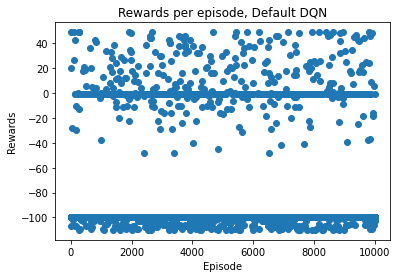

In [130]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Default DQN")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

In [131]:
# Save the data
# get a reference to the file in write bytes mode
with open('data/NoImprovementRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)
with open('data/NoImprovementRaw/mean_rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), 'data/NoImprovementRaw/qnet.pth')

## Double Q

In [117]:
# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

# start training the network
rewards = []
for episode in range(10000):
    # Get an instance of the map
    amap = AdvancedMap()
    # Get the normalised observations
    obs, reward, done = amap.convert_observations(amap.reset())

    # setup the total reward
    total_reward = 0

    steps_done = 0

    while not done:
        Q_net.eval()
        # put the state into a tensor
        state = torch.from_numpy(obs).unsqueeze(0)
        
        # pick an action and increment the number of steps
        action, steps_done = select_action(state, steps_done), steps_done + 1
        
        # get the action
        action = adv_action_from_index(action.item())

        # take the action
        next_state, reward, done = amap.convert_observations(amap.step(action))

        # add to the reward
        total_reward += reward

        # set next state to nothing if we're done
        if done:
            next_state = None

        # add to the memories
        memory.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device))

        # pass the next_state through to the next round
        obs = next_state

    # train the model
    Q_net.train()
    loss = optimise_model(doubleQ=True)

    # add the rewards history
    rewards.append(total_reward)

    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    
    # work out the mean rewards
    mean_rewards = np.mean(rewards)
    # print info
    print(f"Episode: {episode}, reward: {total_reward}, loss: {loss.item()}, Mean reward: {mean_rewards}")

    # early stopping
    if mean_rewards > 0:
        print("Stopped early")
        break

Episode: 0, reward: -100, loss: 10.709027290344238
Episode: 1, reward: -100, loss: 4.158712387084961
Episode: 2, reward: -100, loss: 0.916574239730835
Episode: 3, reward: -100, loss: 0.9827249646186829
Episode: 4, reward: -100, loss: 4.703725814819336
Episode: 5, reward: -100, loss: 1.3527021408081055
Episode: 6, reward: -100, loss: 0.9238661527633667
Episode: 7, reward: -100, loss: 0.8930126428604126
Episode: 8, reward: -100, loss: 0.8407575488090515
Episode: 9, reward: -100, loss: 0.9362266063690186
Episode: 10, reward: -100, loss: 0.8807010054588318
Episode: 11, reward: -51, loss: 1.3503228425979614
Episode: 12, reward: -100, loss: 0.9188555479049683
Episode: 13, reward: -100, loss: 10.408291816711426
Episode: 14, reward: -100, loss: 10.894044876098633
Episode: 15, reward: -100, loss: 21.148038864135742
Episode: 16, reward: -100, loss: 1.3041739463806152
Episode: 17, reward: -100, loss: 10.543458938598633
Episode: 18, reward: -100, loss: 0.9282000064849854
Episode: 19, reward: -100,

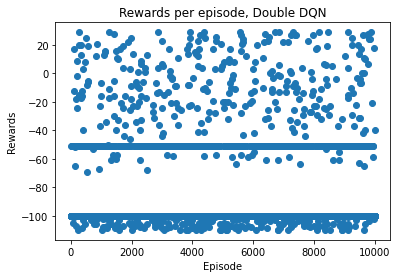

In [118]:
# plot the rewards per episode
plt.scatter(list(range(len(rewards))), rewards)
plt.title("Rewards per episode, Double DQN")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.show()

In [119]:
# Save the data
# get a reference to the file in write bytes mode
with open('data/DoubleQRaw/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(rewards, f)

# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), 'data/DoubleQRaw/qnet.pth')